<a href="https://colab.research.google.com/github/codyub/codyub/blob/main/GAN_practice_400.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고 git: https://happy-jihye.github.io/gan/gan-1/

In [1]:
import torch
import torch.nn as nn

import numpy as np

# for MNIST data
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.autograd import Variable


import matplotlib.pyplot as plt

# Preparing data: FashionMNIST로 도전!

In [2]:
# download the MINST data

batch_size = 64

transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(), # data를 pytorch의 tensor형식으로 바꿉니다
    transforms.Normalize([0.5], [0.5]) # 픽셀값을 0 ~ 1에서 -1 ~ 1 로 바꿔줍니다.
])

train_dataset = torchvision.datasets.FashionMNIST(root="./dataset", train=True, download=True, transform=transforms_train)

# data를 batch size만큼만 가져오는 dataloader를 만듭니다.
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=4)

100%|██████████| 26421880/26421880 [00:01<00:00, 16569280.68it/s]


Extracting ./dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 303616.78it/s]


Extracting ./dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5549261.30it/s]


Extracting ./dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20741860.70it/s]


Extracting ./dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


- 하나의 batch에 들어있는 data 출력

[tensor(1), tensor(0), tensor(5), tensor(8), tensor(6), tensor(7), tensor(8), tensor(3), tensor(6), tensor(6), tensor(1), tensor(0), tensor(5), tensor(4), tensor(2), tensor(5), tensor(5), tensor(5), tensor(6), tensor(7), tensor(0), tensor(3), tensor(2), tensor(0), tensor(8), tensor(6), tensor(4), tensor(0), tensor(3), tensor(8), tensor(2), tensor(2), tensor(3), tensor(5), tensor(1), tensor(7), tensor(6), tensor(4), tensor(6), tensor(9), tensor(0), tensor(1), tensor(3), tensor(0), tensor(3), tensor(8), tensor(1), tensor(6), tensor(8), tensor(7), tensor(3), tensor(8), tensor(7), tensor(3), tensor(0), tensor(1), tensor(6), tensor(0), tensor(9), tensor(7), tensor(4), tensor(4), tensor(0), tensor(5)]


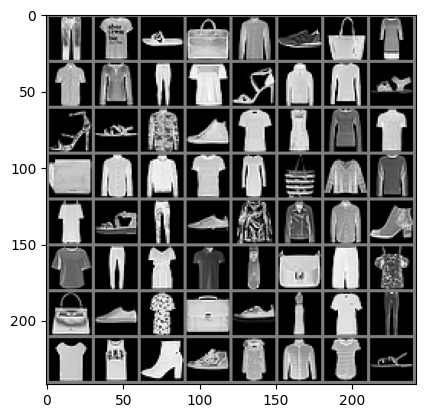

In [3]:
images, labels = next(iter(dataloader))
img = torchvision.utils.make_grid(images)

img = img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
print([labels[i] for i in range(64)])
plt.imshow(img)

In [4]:
# image

channels = 1
img_size = 28

img_shape = (channels, img_size, img_size)

# Build Model
- 이 튜토리얼에서는 잠재공간의 크기를 100으로 뒀으며, 잠재공간의 크기에는 제한이 없으나 나타내려고 하는 대상의 정보를 충분히 담을 수 있을 만큼 커야합니다.


In [5]:
# dimensionality of the latent space
# latent vector를 추출하기 위한 noise 분포의 dimension (정규분포를 따름)
latent_dim = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # generater의 model은 여러개의 block을 쌓아서 만들어짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        # z : input noise vector
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

# Loss Function & Optimizer
손실 함수로는 Binary Cross Entropy(-> nn.CrossEntropyLoss(이진 아니니까)를, 최적화 함수로는 Adam을 사용합니다.

In [7]:
''' Hyper parameter '''
# learning rate
lr = 0.0002

# decay of first order momentum of gradient
b1 = 0.5
b2 = 0.999


# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Loss function
adversarial_loss = nn.BCELoss(); # 손실함수

# Adam Optimizer
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [8]:
# GPU
cuda = True if torch.cuda.is_available() else False

if cuda :
  generator.cuda()
  discriminator.cuda()
  adversarial_loss.cuda()

# Training

In [ ]:
import time

# number of epochs of training
n_epochs = 200

# interval between image samples
sample_interval = 2000

start_time = time.time()

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        ## 실제 이미지는 1로, 가짜 이미지는 0으로 label됩니다.
        real = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        ## random sampling한 값인 z를 생성자에 넣어 이미지를 생성합니다.
        generated_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        ## 생성된 이미지를 discriminator가 판별하게 한 후, loss값을 계산합니다.
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        ## 실제 이미지는 real(1)로, 가짜 이미지는 fake(0)으로 판별하도록 계산합니다.
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"data{epoch}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.252871] [G loss: 1.406450] [Elapsed time: 22.76s]
[Epoch 1/200] [D loss: 0.358193] [G loss: 1.143021] [Elapsed time: 44.16s]
[Epoch 2/200] [D loss: 0.258780] [G loss: 2.077616] [Elapsed time: 66.75s]
[Epoch 3/200] [D loss: 0.440002] [G loss: 1.163985] [Elapsed time: 89.57s]
[Epoch 4/200] [D loss: 0.460134] [G loss: 1.266407] [Elapsed time: 113.30s]
[Epoch 5/200] [D loss: 0.232922] [G loss: 1.608567] [Elapsed time: 135.74s]
[Epoch 6/200] [D loss: 0.330107] [G loss: 2.156749] [Elapsed time: 158.53s]
[Epoch 7/200] [D loss: 0.477814] [G loss: 2.874632] [Elapsed time: 180.75s]
[Epoch 8/200] [D loss: 0.285838] [G loss: 1.220608] [Elapsed time: 202.82s]
[Epoch 9/200] [D loss: 0.306174] [G loss: 1.164172] [Elapsed time: 225.76s]
[Epoch 10/200] [D loss: 0.486029] [G loss: 1.778299] [Elapsed time: 249.77s]
[Epoch 11/200] [D loss: 0.325462] [G loss: 1.412803] [Elapsed time: 271.43s]
[Epoch 12/200] [D loss: 0.363985] [G loss: 1.943078] [Elapsed time: 295.53s]
[Epoch 13/200

In [ ]:
generated_25 = generated_imgs.data[:100]

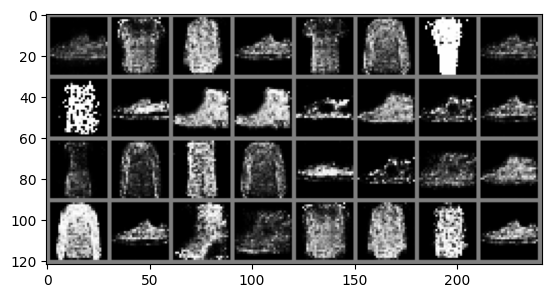

In [ ]:
img = torchvision.utils.make_grid(generated_25)

img = img.cpu().numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
#print([labels[i] for i in range(64)])
plt.imshow(img)

# epoch 2배로 늘려서 재도전!

In [9]:
import time

# number of epochs of training
n_epochs = 400

# interval between image samples
sample_interval = 2000

start_time = time.time()

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        ## 실제 이미지는 1로, 가짜 이미지는 0으로 label됩니다.
        real = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        ## random sampling한 값인 z를 생성자에 넣어 이미지를 생성합니다.
        generated_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        ## 생성된 이미지를 discriminator가 판별하게 한 후, loss값을 계산합니다.
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        ## 실제 이미지는 real(1)로, 가짜 이미지는 fake(0)으로 판별하도록 계산합니다.
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"data{epoch}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/400] [D loss: 0.211991] [G loss: 3.793648] [Elapsed time: 38.56s]
[Epoch 1/400] [D loss: 0.601699] [G loss: 3.235007] [Elapsed time: 60.54s]
[Epoch 2/400] [D loss: 0.377269] [G loss: 1.508803] [Elapsed time: 83.00s]
[Epoch 3/400] [D loss: 0.285572] [G loss: 1.294825] [Elapsed time: 105.98s]
[Epoch 4/400] [D loss: 0.331823] [G loss: 1.855184] [Elapsed time: 128.50s]
[Epoch 5/400] [D loss: 0.423468] [G loss: 1.027274] [Elapsed time: 150.52s]
[Epoch 6/400] [D loss: 0.363267] [G loss: 1.474200] [Elapsed time: 173.75s]
[Epoch 7/400] [D loss: 0.340429] [G loss: 1.458861] [Elapsed time: 198.18s]
[Epoch 8/400] [D loss: 0.798887] [G loss: 3.957202] [Elapsed time: 220.23s]
[Epoch 9/400] [D loss: 0.427617] [G loss: 1.519161] [Elapsed time: 243.38s]
[Epoch 10/400] [D loss: 0.452501] [G loss: 1.443576] [Elapsed time: 266.08s]
[Epoch 11/400] [D loss: 0.443728] [G loss: 0.962608] [Elapsed time: 287.71s]
[Epoch 12/400] [D loss: 0.443965] [G loss: 1.073393] [Elapsed time: 311.05s]
[Epoch 13/40

In [10]:
generated_25 = generated_imgs.data[:100]

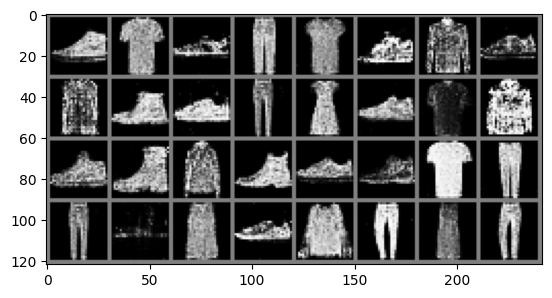

In [11]:
img = torchvision.utils.make_grid(generated_25)

img = img.cpu().numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
#print([labels[i] for i in range(64)])
plt.imshow(img)